# Degradation Modelling 

This rover shows how degradation modelling can be performed to model the resilience of an engineered system over its entire lifecycle.

In [1]:
import fmdtools.analyze as an
import fmdtools.sim.propagate as prop
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

In [2]:
from examples.rover.rover_degradation import DriveDegradation, PSFDegradationLong, PSFDegradationShort

Degradation models are defined independently of the fault model, but have attributes (e.g., functions) which may correspond to it directly.

Because degradation may only occur in specific functions/flows (and may not have inter-functional dependencies), it is not necessary for the degradation model to have the same 

In [3]:
deg_mdl = DriveDegradation()
deg_mdl

drivedegradation DriveDegradation
- DriveDegradationStates(wear=0.0, corrosion=0.0, friction=0.0, drift=0.0)

In [4]:
deg_mdl_hum_long = PSFDegradationLong()
deg_mdl_hum_long

psfdegradationlong PSFDegradationLong
- PSFDegradationLongStates(experience=0.0)

In [5]:
deg_mdl_hum_short = PSFDegradationShort()
deg_mdl_hum_short

psfdegradationshort PSFDegradationShort
- PSFDegradationShortStates(fatigue=0.0, stress=0.0, experience=1.0)

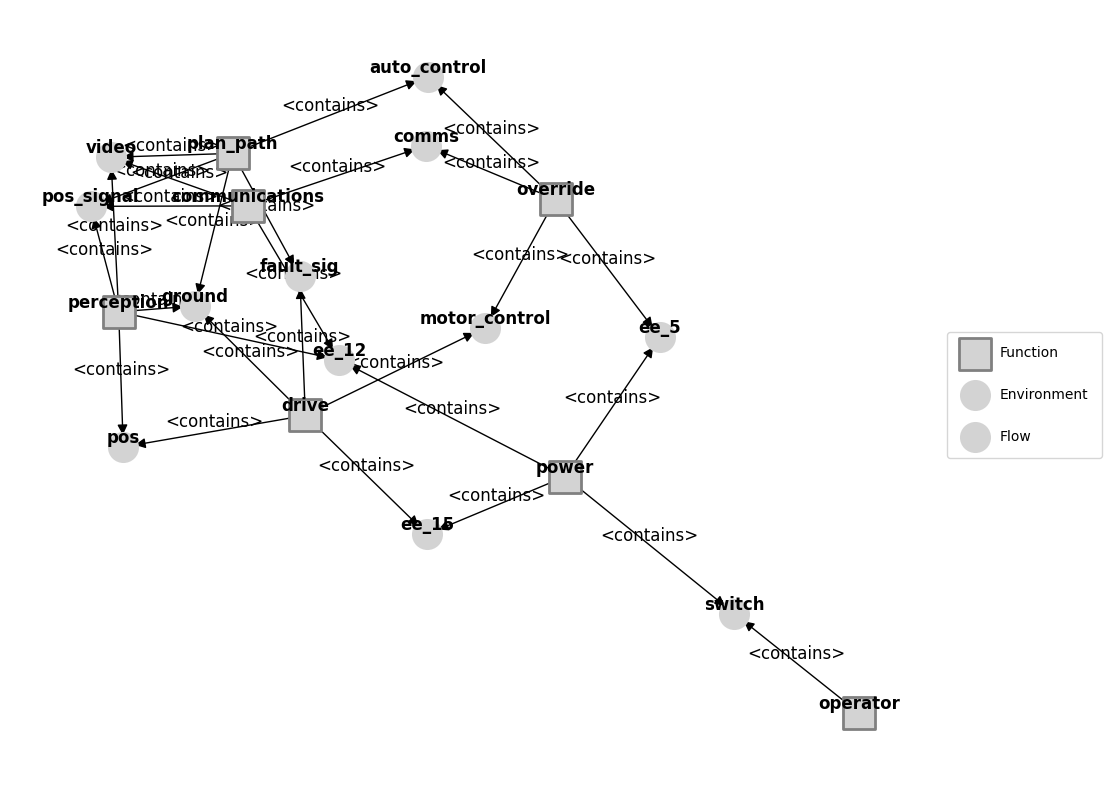

In [6]:
from examples.rover.rover_model import Rover, plot_map
fault_mdl = Rover(p={'ground':{'linetype': 'turn'}})
graph = an.graph.FunctionArchitectureGraph(fault_mdl)
fig, ax = graph.draw()

In [7]:
fig.savefig("func_model.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

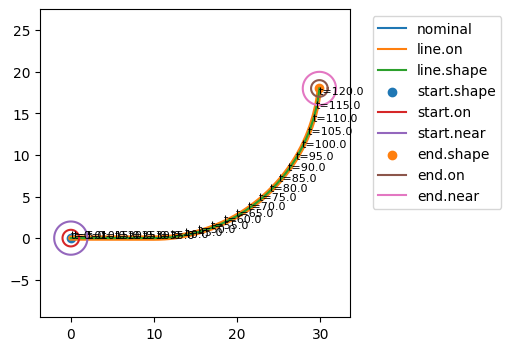

In [8]:
endresults, mdlhist = prop.nominal(fault_mdl)
fig, ax = plot_map(fault_mdl, mdlhist)

In [9]:
fig.savefig("sine_rover_environment.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, there are two degradation models here:
- one which focusses solely on faults in the drive system, and
- one which focusses on the human degradation of fatigue
Below we simulate these to model to the degradation behaviors being modelled in this drive system.

## Drive Degradation

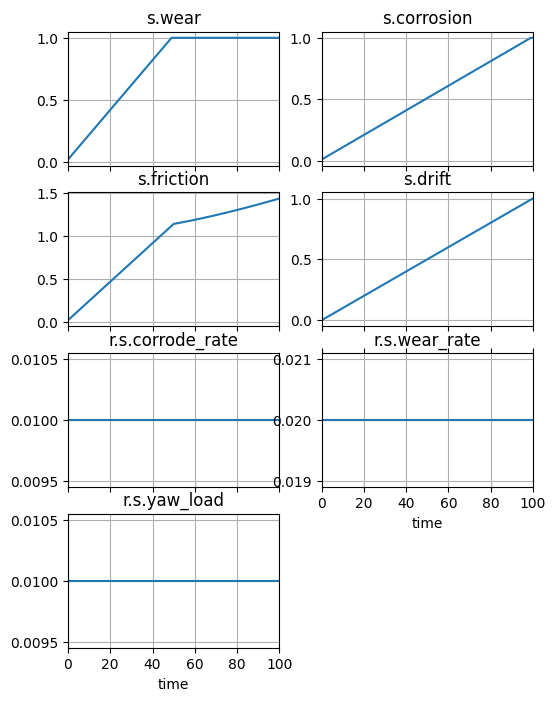

In [10]:
deg_mdl = DriveDegradation()
endresults, mdlhist = prop.nominal(deg_mdl)
fig, ax = mdlhist.plot_line('s.wear', 's.corrosion', 's.friction', 's.drift', 'r.s.corrode_rate', 'r.s.wear_rate', 'r.s.yaw_load')

The major behaviors are:
- wear
- corrosion
- friction
- drift

These behaviors result from the accumulation of the following rates over each time-step:
- yaw_load 
- corrode_rate
- wear_rate

These degradation behaviors have additionally been defined to simulate stochastically if desired:

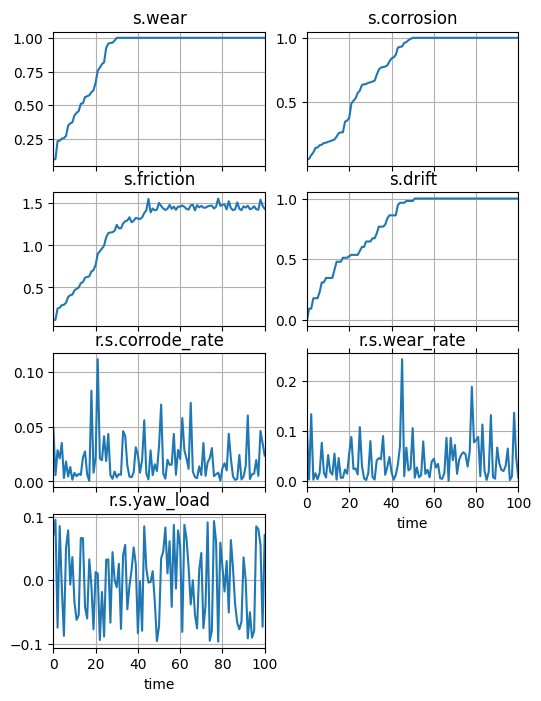

In [11]:
deg_mdl = DriveDegradation()
endresults, mdlhist = prop.nominal(deg_mdl, run_stochastic=True)
fig, ax = mdlhist.plot_line('s.wear', 's.corrosion', 's.friction', 's.drift', 'r.s.corrode_rate', 'r.s.wear_rate', 'r.s.yaw_load')

To get averages/percentages over a number of scenarios, we can view these behaviors over a given number of random seeds:

In [12]:
from fmdtools.sim.sample import ParameterSample
ps = ParameterSample()
ps.add_variable_replicates([], replicates=100, seed_comb='independent')
endclasses_deg, mdlhists_deg = prop.parameter_sample(deg_mdl, ps, run_stochastic=True)

SCENARIOS COMPLETE:   0%|          | 0/100 [00:00<?, ?it/s]

SCENARIOS COMPLETE:  11%|█         | 11/100 [00:00<00:00, 105.64it/s]

SCENARIOS COMPLETE:  23%|██▎       | 23/100 [00:00<00:00, 109.51it/s]

SCENARIOS COMPLETE:  34%|███▍      | 34/100 [00:00<00:00, 108.80it/s]

SCENARIOS COMPLETE:  45%|████▌     | 45/100 [00:00<00:00, 107.61it/s]

SCENARIOS COMPLETE:  56%|█████▌    | 56/100 [00:00<00:00, 108.30it/s]

SCENARIOS COMPLETE:  68%|██████▊   | 68/100 [00:00<00:00, 109.71it/s]

SCENARIOS COMPLETE:  79%|███████▉  | 79/100 [00:00<00:00, 109.64it/s]

SCENARIOS COMPLETE:  90%|█████████ | 90/100 [00:00<00:00, 109.58it/s]

SCENARIOS COMPLETE: 100%|██████████| 100/100 [00:00<00:00, 108.03it/s]

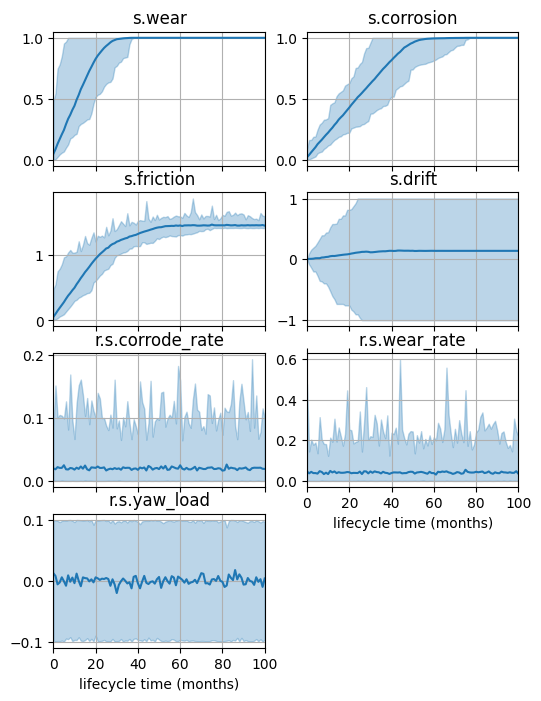

In [13]:
fig, ax = mdlhists_deg.plot_line('s.wear', 's.corrosion', 's.friction', 's.drift',
                                 'r.s.corrode_rate', 'r.s.wear_rate', 'r.s.yaw_load',
                                 title="", xlabel='lifecycle time (months)', aggregation = 'mean_bound')

In [14]:
fig.savefig("drive_degradations.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, while wear and friction proceed monotonically, drift can go one way or another, meaning that whether the rover drifts left or right is basically up to chance. We can further look at slices of these distributions:

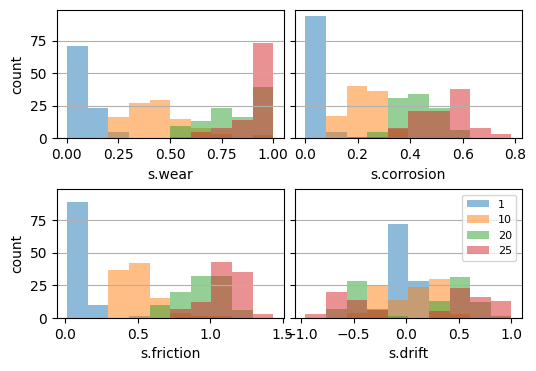

In [15]:
fig, axs = mdlhists_deg.plot_metric_dist([1, 10, 20, 25], 's.wear', 's.corrosion', 's.friction', 's.drift', bins=10, alpha=0.5)

Given the parameter information (friction and drift) that the degradation model produced, we can now simulate the model with this information over time in the nominal scenarios.

In [16]:
from fmdtools.sim.sample import ParameterDomain, ParameterHistSample
from examples.rover.rover_model import RoverParam

We can do this using a `ParameterHistSample` to sample the histories of the various scenarios at different times. 

First, by defining a `ParameterDomain`:

In [17]:
rpd = ParameterDomain(RoverParam)
rpd.add_variables('degradation.friction', 'degradation.drift')
rpd.add_constant('drive_modes', {"mode_args": "degradation"})
rpd(1, 10).degradation

DegParam(friction=1.0, drift=10.0)

And then by defining the class:

In [18]:
phs = ParameterHistSample(mdlhists_deg, 's.friction', 's.drift', paramdomain=rpd)
phs._get_repname('default', 1)
phs.add_hist_groups(reps= 10, ts = [1, 2, 5, 10])
len(phs.scenarios())

40

Simulating the nominal scenario for these parameters:

In [19]:
mdl=Rover(p={'drive_modes': {'mode_args': "degradation"}})
behave_endclasses, behave_mdlhists = prop.parameter_sample(fault_mdl, phs)

SCENARIOS COMPLETE:   0%|          | 0/40 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   2%|▎         | 1/40 [00:00<00:06,  5.92it/s]

SCENARIOS COMPLETE:   5%|▌         | 2/40 [00:00<00:05,  6.97it/s]

SCENARIOS COMPLETE:   8%|▊         | 3/40 [00:00<00:04,  7.40it/s]

SCENARIOS COMPLETE:  10%|█         | 4/40 [00:00<00:04,  7.61it/s]

SCENARIOS COMPLETE:  12%|█▎        | 5/40 [00:00<00:05,  6.95it/s]

SCENARIOS COMPLETE:  15%|█▌        | 6/40 [00:00<00:05,  6.61it/s]

SCENARIOS COMPLETE:  18%|█▊        | 7/40 [00:01<00:05,  6.27it/s]

SCENARIOS COMPLETE:  20%|██        | 8/40 [00:01<00:04,  6.88it/s]

SCENARIOS COMPLETE:  22%|██▎       | 9/40 [00:01<00:04,  6.61it/s]

SCENARIOS COMPLETE:  25%|██▌       | 10/40 [00:01<00:04,  6.40it/s]

SCENARIOS COMPLETE:  28%|██▊       | 11/40 [00:01<00:04,  6.65it/s]

SCENARIOS COMPLETE:  30%|███       | 12/40 [00:01<00:03,  7.00it/s]

SCENARIOS COMPLETE:  32%|███▎      | 13/40 [00:01<00:03,  7.47it/s]

SCENARIOS COMPLETE:  35%|███▌      | 14/40 [00:02<00:03,  7.61it/s]

SCENARIOS COMPLETE:  38%|███▊      | 15/40 [00:02<00:03,  7.87it/s]

SCENARIOS COMPLETE:  40%|████      | 16/40 [00:02<00:02,  8.15it/s]

SCENARIOS COMPLETE:  42%|████▎     | 17/40 [00:02<00:03,  7.37it/s]

SCENARIOS COMPLETE:  45%|████▌     | 18/40 [00:02<00:03,  6.90it/s]

SCENARIOS COMPLETE:  48%|████▊     | 19/40 [00:02<00:02,  7.19it/s]

SCENARIOS COMPLETE:  50%|█████     | 20/40 [00:02<00:02,  7.66it/s]

SCENARIOS COMPLETE:  52%|█████▎    | 21/40 [00:02<00:02,  7.00it/s]

SCENARIOS COMPLETE:  55%|█████▌    | 22/40 [00:03<00:02,  7.20it/s]

SCENARIOS COMPLETE:  57%|█████▊    | 23/40 [00:03<00:02,  7.57it/s]

SCENARIOS COMPLETE:  60%|██████    | 24/40 [00:03<00:02,  7.86it/s]

SCENARIOS COMPLETE:  62%|██████▎   | 25/40 [00:03<00:02,  7.15it/s]

SCENARIOS COMPLETE:  65%|██████▌   | 26/40 [00:03<00:02,  6.81it/s]

SCENARIOS COMPLETE:  68%|██████▊   | 27/40 [00:03<00:01,  6.51it/s]

SCENARIOS COMPLETE:  70%|███████   | 28/40 [00:04<00:01,  6.31it/s]

SCENARIOS COMPLETE:  72%|███████▎  | 29/40 [00:04<00:01,  6.26it/s]

SCENARIOS COMPLETE:  75%|███████▌  | 30/40 [00:04<00:01,  6.04it/s]

SCENARIOS COMPLETE:  78%|███████▊  | 31/40 [00:04<00:01,  6.76it/s]

SCENARIOS COMPLETE:  80%|████████  | 32/40 [00:04<00:01,  6.99it/s]

SCENARIOS COMPLETE:  82%|████████▎ | 33/40 [00:04<00:01,  6.62it/s]

SCENARIOS COMPLETE:  85%|████████▌ | 34/40 [00:04<00:00,  6.58it/s]

SCENARIOS COMPLETE:  88%|████████▊ | 35/40 [00:05<00:00,  6.86it/s]

SCENARIOS COMPLETE:  90%|█████████ | 36/40 [00:05<00:00,  7.31it/s]

SCENARIOS COMPLETE:  92%|█████████▎| 37/40 [00:05<00:00,  6.82it/s]

SCENARIOS COMPLETE:  95%|█████████▌| 38/40 [00:05<00:00,  7.03it/s]

SCENARIOS COMPLETE:  98%|█████████▊| 39/40 [00:05<00:00,  7.44it/s]

SCENARIOS COMPLETE: 100%|██████████| 40/40 [00:05<00:00,  7.77it/s]

SCENARIOS COMPLETE: 100%|██████████| 40/40 [00:05<00:00,  7.03it/s]

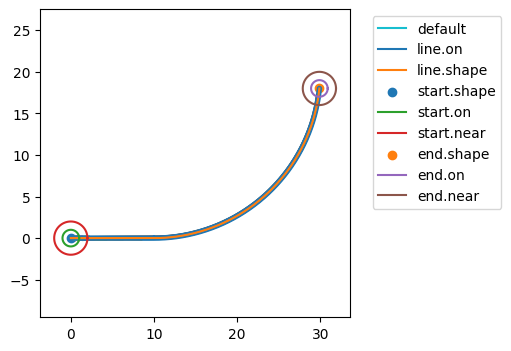

In [20]:
fig, ax = plot_map(fault_mdl, behave_mdlhists)

In [21]:
behave_endclasses.state_probabilities('prob')

{'nominal mission': 18.0, 'incomplete mission': 22.0}

In [22]:
from fmdtools.analyze.tabulate import NominalEnvelope

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='p.degradation.friction', ylabel='p.degradation.drift'>)

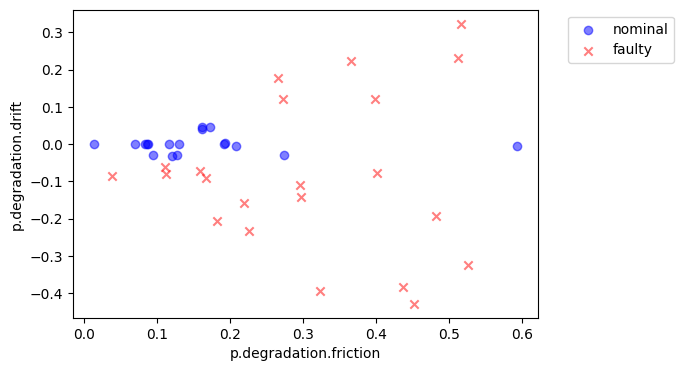

In [23]:
ne = NominalEnvelope(phs, behave_endclasses, 'classification',
                     'p.degradation.friction', 'p.degradation.drift',
                     func = lambda x: x == 'nominal mission')
ne.plot_scatter()

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='inputparams.t', ylabel='inputparams.rep'>)

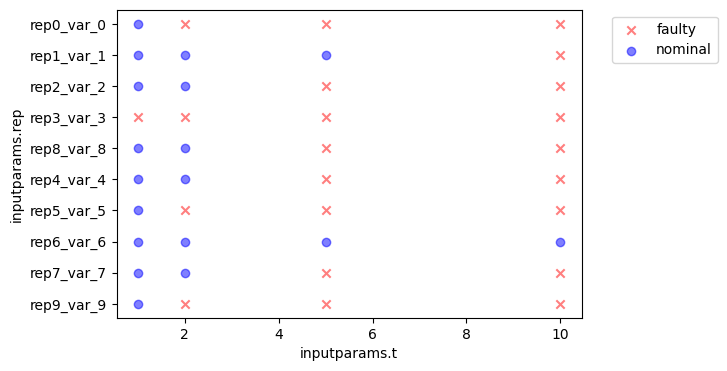

In [24]:
ne = NominalEnvelope(phs, behave_endclasses, 'classification',
                     'inputparams.t', 'inputparams.rep',
                     func = lambda x: x == 'nominal mission')
ne.plot_scatter()

In [25]:
fig.savefig("drive_deg_envelope.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, as the time (and thus degradation) increases, the rover becomes more likely to be unable to complete the mission. In this case, it results in the rover not completing the mission in time.

In [26]:
from fmdtools.sim.sample import SampleApproach
sa = SampleApproach(mdl)
sa.add_faultdomain('drive_faults', 'all_fxnclass_modes', 'Drive')
sa.add_faultsample('drive_faults', 'fault_phases', 'drive_faults',"start")
# sa.scenarios()

In [27]:
sa.scenarios()

[SingleFaultScenario(sequence={15.0: Injection(faults={'drive': ['elec_open']}, disturbances={})}, times=(15.0,), function='drive', fault='elec_open', rate=0.25, name='drive_elec_open_t15p0', time=15.0, phase='start'),
 SingleFaultScenario(sequence={15.0: Injection(faults={'drive': ['stuck']}, disturbances={})}, times=(15.0,), function='drive', fault='stuck', rate=0.25, name='drive_stuck_t15p0', time=15.0, phase='start'),
 SingleFaultScenario(sequence={15.0: Injection(faults={'drive': ['stuck_right']}, disturbances={})}, times=(15.0,), function='drive', fault='stuck_right', rate=0.25, name='drive_stuck_right_t15p0', time=15.0, phase='start'),
 SingleFaultScenario(sequence={15.0: Injection(faults={'drive': ['stuck_left']}, disturbances={})}, times=(15.0,), function='drive', fault='stuck_left', rate=0.25, name='drive_stuck_left_t15p0', time=15.0, phase='start')]

In [28]:
ec_nest, hist_nest, app_nest = prop.nested_sample(mdl, phs, faultdomains={'drive_faults':  (('all_fxnclass_modes', 'Drive'), {})},
                                                  faultsamples={'drive_faults': (('fault_phases', 'drive_faults', "start"), {})},
                                                  pool=mp.Pool(5))


NESTED SCENARIOS COMPLETE:   0%|          | 0/40 [00:00<?, ?it/s]

NESTED SCENARIOS COMPLETE:   2%|▎         | 1/40 [00:00<00:26,  1.49it/s]

NESTED SCENARIOS COMPLETE:   5%|▌         | 2/40 [00:00<00:15,  2.42it/s]

NESTED SCENARIOS COMPLETE:   8%|▊         | 3/40 [00:01<00:12,  2.99it/s]

NESTED SCENARIOS COMPLETE:  10%|█         | 4/40 [00:01<00:10,  3.41it/s]

NESTED SCENARIOS COMPLETE:  12%|█▎        | 5/40 [00:01<00:09,  3.69it/s]

NESTED SCENARIOS COMPLETE:  15%|█▌        | 6/40 [00:01<00:08,  3.88it/s]

NESTED SCENARIOS COMPLETE:  18%|█▊        | 7/40 [00:02<00:10,  3.10it/s]

NESTED SCENARIOS COMPLETE:  20%|██        | 8/40 [00:02<00:09,  3.37it/s]

NESTED SCENARIOS COMPLETE:  22%|██▎       | 9/40 [00:03<00:11,  2.63it/s]

NESTED SCENARIOS COMPLETE:  25%|██▌       | 10/40 [00:03<00:12,  2.32it/s]

NESTED SCENARIOS COMPLETE:  28%|██▊       | 11/40 [00:03<00:10,  2.64it/s]

NESTED SCENARIOS COMPLETE:  30%|███       | 12/40 [00:04<00:09,  2.99it/s]

NESTED SCENARIOS COMPLETE:  32%|███▎      | 13/40 [00:04<00:08,  3.33it/s]

NESTED SCENARIOS COMPLETE:  35%|███▌      | 14/40 [00:04<00:07,  3.58it/s]

NESTED SCENARIOS COMPLETE:  38%|███▊      | 15/40 [00:04<00:06,  3.74it/s]

NESTED SCENARIOS COMPLETE:  40%|████      | 16/40 [00:05<00:06,  3.87it/s]

NESTED SCENARIOS COMPLETE:  42%|████▎     | 17/40 [00:05<00:08,  2.84it/s]

NESTED SCENARIOS COMPLETE:  45%|████▌     | 18/40 [00:05<00:07,  3.11it/s]

NESTED SCENARIOS COMPLETE:  48%|████▊     | 19/40 [00:06<00:06,  3.34it/s]

NESTED SCENARIOS COMPLETE:  50%|█████     | 20/40 [00:06<00:05,  3.56it/s]

NESTED SCENARIOS COMPLETE:  52%|█████▎    | 21/40 [00:06<00:07,  2.70it/s]

NESTED SCENARIOS COMPLETE:  55%|█████▌    | 22/40 [00:07<00:06,  2.98it/s]

NESTED SCENARIOS COMPLETE:  57%|█████▊    | 23/40 [00:07<00:05,  3.23it/s]

NESTED SCENARIOS COMPLETE:  60%|██████    | 24/40 [00:07<00:04,  3.47it/s]

NESTED SCENARIOS COMPLETE:  62%|██████▎   | 25/40 [00:08<00:05,  2.68it/s]

NESTED SCENARIOS COMPLETE:  65%|██████▌   | 26/40 [00:08<00:06,  2.32it/s]

NESTED SCENARIOS COMPLETE:  68%|██████▊   | 27/40 [00:09<00:06,  2.07it/s]

NESTED SCENARIOS COMPLETE:  70%|███████   | 28/40 [00:09<00:06,  1.97it/s]

NESTED SCENARIOS COMPLETE:  72%|███████▎  | 29/40 [00:10<00:05,  1.89it/s]

NESTED SCENARIOS COMPLETE:  75%|███████▌  | 30/40 [00:10<00:04,  2.19it/s]

NESTED SCENARIOS COMPLETE:  78%|███████▊  | 31/40 [00:11<00:03,  2.55it/s]

NESTED SCENARIOS COMPLETE:  80%|████████  | 32/40 [00:11<00:02,  2.88it/s]

NESTED SCENARIOS COMPLETE:  82%|████████▎ | 33/40 [00:11<00:02,  3.14it/s]

NESTED SCENARIOS COMPLETE:  85%|████████▌ | 34/40 [00:11<00:01,  3.30it/s]

NESTED SCENARIOS COMPLETE:  88%|████████▊ | 35/40 [00:12<00:01,  3.51it/s]

NESTED SCENARIOS COMPLETE:  90%|█████████ | 36/40 [00:12<00:01,  3.65it/s]

NESTED SCENARIOS COMPLETE:  92%|█████████▎| 37/40 [00:12<00:01,  2.83it/s]

NESTED SCENARIOS COMPLETE:  95%|█████████▌| 38/40 [00:13<00:00,  3.11it/s]

NESTED SCENARIOS COMPLETE:  98%|█████████▊| 39/40 [00:13<00:00,  3.34it/s]

NESTED SCENARIOS COMPLETE: 100%|██████████| 40/40 [00:13<00:00,  3.68it/s]

NESTED SCENARIOS COMPLETE: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]

Finally, we can also visualize simulate and then view the effect of the degradation on average resilience...

In [29]:
from fmdtools.analyze.tabulate import NestedComparison
nc = NestedComparison(ec_nest, phs, ['inputparams.t'], app_nest, ['fault'], metrics=['tot_deviation', 'end_dist'], default_stat=np.mean, ci_metrics=['end_dist', 'tot_deviation'])

In [30]:
nc

{'tot_deviation': {(1, 'stuck_right'): 0.2094089421497654, (1, 'elec_open'): 0.14848913883320647, (1, 'stuck'): 0.14848913883320647, (1, 'stuck_left'): 0.23545902631952892, (2, 'stuck_right'): 0.2156689565525654, (2, 'elec_open'): 0.20151460388629427, (2, 'stuck'): 0.20151460388629427, (2, 'stuck_left'): 0.223557064705226, (10, 'stuck_right'): 0.2376090408911138, (10, 'elec_open'): 0.22652596600408875, (10, 'stuck'): 0.22652596600408875, (10, 'stuck_left'): 0.23459788473168958, (5, 'stuck_right'): 0.23002457955528843, (5, 'elec_open'): 0.21297230928386707, (5, 'stuck'): 0.21297230928386707, (5, 'stuck_left'): 0.23044469643885881}, 'end_dist': {(1, 'stuck_right'): 26.101970314129858, (1, 'elec_open'): 26.60326515687766, (1, 'stuck'): 26.534526974966685, (1, 'stuck_left'): 25.60676683232024, (2, 'stuck_right'): 27.5474591713331, (2, 'elec_open'): 27.67846167931605, (2, 'stuck'): 27.65809130333301, (2, 'stuck_left'): 27.393533445802785, (10, 'stuck_right'): 27.840945054757746, (10, 'elec_

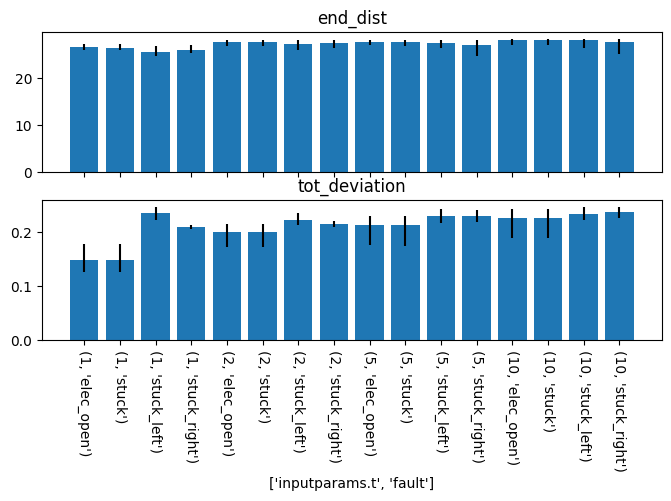

In [31]:
nc.sort_by_factor("fault")
nc.sort_by_factor("inputparams.t")
fig, ax = nc.as_plots('end_dist', 'tot_deviation', figsize=(8,4))

In [32]:
nc

{'tot_deviation': {(1, 'elec_open'): 0.14848913883320647, (1, 'stuck'): 0.14848913883320647, (1, 'stuck_left'): 0.23545902631952892, (1, 'stuck_right'): 0.2094089421497654, (2, 'elec_open'): 0.20151460388629427, (2, 'stuck'): 0.20151460388629427, (2, 'stuck_left'): 0.223557064705226, (2, 'stuck_right'): 0.2156689565525654, (5, 'elec_open'): 0.21297230928386707, (5, 'stuck'): 0.21297230928386707, (5, 'stuck_left'): 0.23044469643885881, (5, 'stuck_right'): 0.23002457955528843, (10, 'elec_open'): 0.22652596600408875, (10, 'stuck'): 0.22652596600408875, (10, 'stuck_left'): 0.23459788473168958, (10, 'stuck_right'): 0.2376090408911138}, 'end_dist': {(1, 'elec_open'): 26.60326515687766, (1, 'stuck'): 26.534526974966685, (1, 'stuck_left'): 25.60676683232024, (1, 'stuck_right'): 26.101970314129858, (2, 'elec_open'): 27.67846167931605, (2, 'stuck'): 27.65809130333301, (2, 'stuck_left'): 27.393533445802785, (2, 'stuck_right'): 27.5474591713331, (5, 'elec_open'): 27.825524146839193, (5, 'stuck'): 

In [33]:
# fig.savefig("drive_resilience_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, while there is some resilience early in the lifecycle (resulting in a small proportion of faults being recovered), this resilience goes away with degradation.

## Human Degradation

We can also perform this assessment for the human error model, which is split up into two parts:
- long term "degradation" of experience over months
- short term "degradation" of stress and fatigue over a day

In [34]:
psf_long = PSFDegradationLong()
endresults,  hist_psf_long = prop.nominal(psf_long)

(<Figure size 300x200 with 1 Axes>,
 [<Axes: title={'center': 's.experience'}, xlabel='time'>])

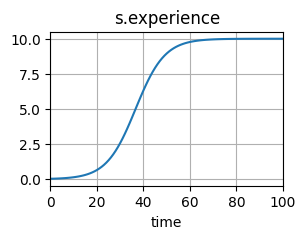

In [35]:
hist_psf_long.plot_line('s.experience')

(<Figure size 300x200 with 1 Axes>,
 [<Axes: title={'center': 's.experience'}, xlabel='time'>])

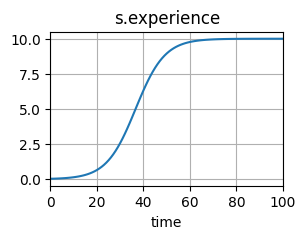

In [36]:
hist_psf_long.plot_line('s.experience')

In [37]:
from examples.rover.rover_degradation import LongParams
pd_hl = ParameterDomain(LongParams)
pd_hl.add_variable("experience_param", var_lim=())
pd_hl

ParameterDomain with:
 - variables: {'experience_param': ()}
 - constants: {}
 - parameter_initializer: LongParams

In [38]:
pd_hl(10)

LongParams(experience_param=10.0, training_frequency=8.0, experience_scale_max=10.0)

In [39]:
ps_hl = ParameterSample(pd_hl)
xs = np.random.default_rng(seed=101).gamma(1,1.9,101)
# round so that dist is 0-10
xs = [min(x, 9.9) for x in xs]
weight = 1/len(xs)
for x in xs:
    ps_hl.add_variable_scenario(x, weight=weight)
ps_hl

ParameterSample of scenarios:
 - var_0
 - var_1
 - var_2
 - var_3
 - var_4
 - var_5
 - var_6
 - var_7
 - var_8
 - var_9
 - ... (101 total)

In [40]:
ec_psf_long, hist_psf_long= prop.parameter_sample(psf_long, ps_hl, run_stochastic=True)

SCENARIOS COMPLETE:   0%|          | 0/101 [00:00<?, ?it/s]

SCENARIOS COMPLETE:  22%|██▏       | 22/101 [00:00<00:00, 206.30it/s]

SCENARIOS COMPLETE:  44%|████▎     | 44/101 [00:00<00:00, 213.90it/s]

SCENARIOS COMPLETE:  65%|██████▌   | 66/101 [00:00<00:00, 216.53it/s]

SCENARIOS COMPLETE:  88%|████████▊ | 89/101 [00:00<00:00, 221.38it/s]

SCENARIOS COMPLETE: 100%|██████████| 101/101 [00:00<00:00, 222.26it/s]

(<Figure size 300x200 with 1 Axes>,
 [<Axes: title={'center': 's.experience'}, xlabel='time'>])

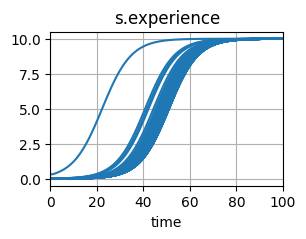

In [41]:
hist_psf_long.plot_line('s.experience')

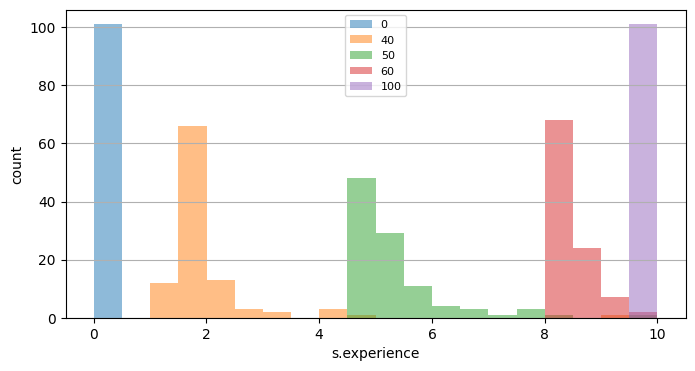

In [42]:
fig, axs = hist_psf_long.plot_metric_dist([0, 40, 50, 60, 100], 's.experience', bins=20, alpha=0.5, figsize=(8,4))

In [43]:
# fig.savefig("experience_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

Short-term degradation

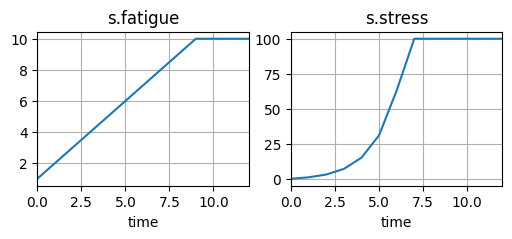

In [44]:
psf_short = PSFDegradationShort()
er, hist_short = prop.nominal(psf_short)
fig, axs = hist_short.plot_line('s.fatigue', 's.stress')

short-term degradation (over no external params)

In [45]:
ps_psf_short = ParameterSample()
ps_psf_short.add_variable_replicates([], replicates=25)
ps_psf_short.scenarios()

[ParameterScenario(sequence={}, times=(), p={}, r={'seed': 1958798798}, sp={}, prob=0.04, inputparams={}, rangeid='', name='rep0_var_0'),
 ParameterScenario(sequence={}, times=(), p={}, r={'seed': 236087761}, sp={}, prob=0.04, inputparams={}, rangeid='', name='rep1_var_1'),
 ParameterScenario(sequence={}, times=(), p={}, r={'seed': 483828007}, sp={}, prob=0.04, inputparams={}, rangeid='', name='rep2_var_2'),
 ParameterScenario(sequence={}, times=(), p={}, r={'seed': 2455692810}, sp={}, prob=0.04, inputparams={}, rangeid='', name='rep3_var_3'),
 ParameterScenario(sequence={}, times=(), p={}, r={'seed': 2827447289}, sp={}, prob=0.04, inputparams={}, rangeid='', name='rep4_var_4'),
 ParameterScenario(sequence={}, times=(), p={}, r={'seed': 2557138441}, sp={}, prob=0.04, inputparams={}, rangeid='', name='rep5_var_5'),
 ParameterScenario(sequence={}, times=(), p={}, r={'seed': 234570186}, sp={}, prob=0.04, inputparams={}, rangeid='', name='rep6_var_6'),
 ParameterScenario(sequence={}, times

SCENARIOS COMPLETE:   0%|          | 0/25 [00:00<?, ?it/s]

SCENARIOS COMPLETE: 100%|██████████| 25/25 [00:00<00:00, 659.88it/s]

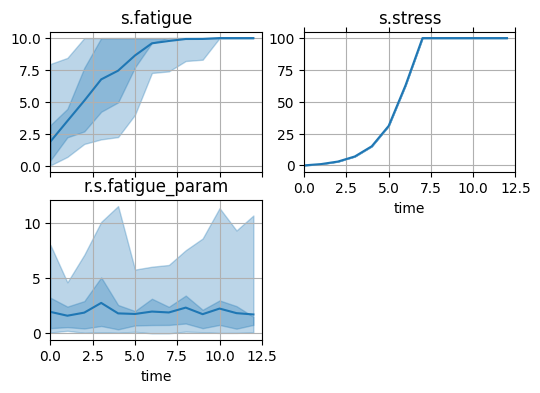

In [46]:
ec_psf_short, hist_psf_short = prop.parameter_sample(psf_short, ps_psf_short, run_stochastic=True)
fig, axs = hist_psf_short.plot_line('s.fatigue', 's.stress', 'r.s.fatigue_param', aggregation="percentile")

short-term degradation over long-term params

In [47]:
from examples.rover.rover_degradation import PSFShortParams
pd_short_long = ParameterDomain(PSFShortParams)
pd_short_long.add_variable("experience")
ps_short_long = ParameterHistSample(hist_psf_long, 's.experience', paramdomain=pd_short_long)
ps_short_long.add_hist_groups(reps= 10, ts = [0, 40, 50, 60, 100])

# note - need to add a way to combine replicates (seeds) over replicates (input times/groups/)

In [48]:
pd_short_long(10)

PSFShortParams(experience=10.0, stress_param=0.0, fatigue_param=1.0)

In [49]:
ps_short_long.scenarios()

[ParameterScenario(sequence={}, times=(), p={'experience': 0.0147852093576427}, r={'seed': 1515531804}, sp={}, prob=1.0, inputparams={'comp_group': 'default', 'rep': 'var_0', 't': 0}, rangeid='', name='hist_0'),
 ParameterScenario(sequence={}, times=(), p={'experience': 4.355521540650882}, r={'seed': 1515531804}, sp={}, prob=1.0, inputparams={'comp_group': 'default', 'rep': 'var_0', 't': 40}, rangeid='', name='hist_1'),
 ParameterScenario(sequence={}, times=(), p={'experience': 7.926159730949486}, r={'seed': 1515531804}, sp={}, prob=1.0, inputparams={'comp_group': 'default', 'rep': 'var_0', 't': 50}, rangeid='', name='hist_2'),
 ParameterScenario(sequence={}, times=(), p={'experience': 9.498252713597697}, r={'seed': 1515531804}, sp={}, prob=1.0, inputparams={'comp_group': 'default', 'rep': 'var_0', 't': 60}, rangeid='', name='hist_3'),
 ParameterScenario(sequence={}, times=(), p={'experience': 9.999122355752638}, r={'seed': 1515531804}, sp={}, prob=1.0, inputparams={'comp_group': 'defa

In [50]:
ec, hist_short_long = prop.parameter_sample(psf_short, ps_short_long, run_stochastic=True)

SCENARIOS COMPLETE:   0%|          | 0/50 [00:00<?, ?it/s]

SCENARIOS COMPLETE: 100%|██████████| 50/50 [00:00<00:00, 588.45it/s]

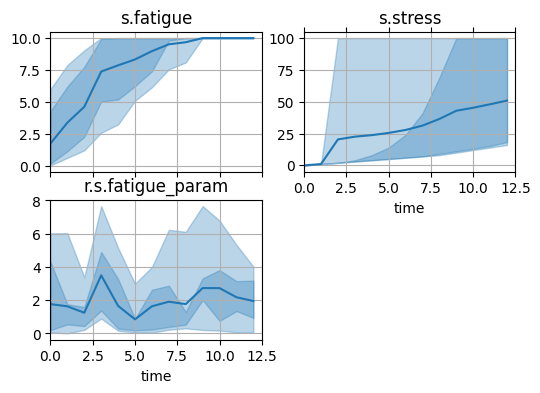

In [51]:
fig, axs = hist_short_long.plot_line('s.fatigue', 's.stress', 'r.s.fatigue_param', aggregation="percentile")

In [52]:
# fig.savefig("stress_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

Now sample in the model:

In [53]:
from examples.rover.rover_model_human import RoverHuman, RoverHumanParam
pd_comb_mdl = ParameterDomain(RoverHumanParam)
# pd_comb_mdl.add_constant('drive_modes', {"mode_args": "degradation"})
pd_comb_mdl.add_variable("psfs.fatigue")
pd_comb_mdl.add_variables("psfs.stress")
rpd.add_constant('drive_modes', {"mode_args": "degradation"})
pd_comb_mdl(1,1)

RoverHumanParam(ground=GroundParam(linetype='sine', amp=1.0, period=6.283185307179586, radius=20.0, x_start=10.0, y_end=10.0, x_min=0.0, x_max=30.0, x_res=0.1, path_buffer_on=0.2, path_buffer_poor=0.3, path_buffer_near=0.4, dest_buffer_on=1.0, dest_buffer_near=2.0), correction=ResCorrection(ub_f=10.0, lb_f=-1.0, ub_t=10.0, lb_t=0.0, ub_d=2.0, lb_d=-2.0, cor_d=0.0, cor_t=0.0, cor_f=0.0), degradation=DegParam(friction=0.0, drift=0.0), drive_modes={'mode_args': 'set'}, psfs=PSFParam(fatigue=1.0, stress=1.0))

In [54]:
ps_comb_mdl = ParameterHistSample(hist_short_long, "s.fatigue", "s.stress", paramdomain=pd_comb_mdl)
ps_comb_mdl.add_hist_groups(reps= 10, ts = [0, 1, 3, 5, 6, 8])
ps_comb_mdl.scenarios()

[ParameterScenario(sequence={}, times=(), p={'psfs': {'fatigue': 0.4333782873005958, 'stress': 0.0}}, r={'seed': 1297498067}, sp={}, prob=1.0, inputparams={'comp_group': 'default', 'rep': 'hist_0', 't': 0}, rangeid='', name='hist_0'),
 ParameterScenario(sequence={}, times=(), p={'psfs': {'fatigue': 1.8897765375857665, 'stress': 1.0}}, r={'seed': 1297498067}, sp={}, prob=1.0, inputparams={'comp_group': 'default', 'rep': 'hist_0', 't': 1}, rangeid='', name='hist_1'),
 ParameterScenario(sequence={}, times=(), p={'psfs': {'fatigue': 6.652742388300764, 'stress': 100.0}}, r={'seed': 1297498067}, sp={}, prob=1.0, inputparams={'comp_group': 'default', 'rep': 'hist_0', 't': 3}, rangeid='', name='hist_2'),
 ParameterScenario(sequence={}, times=(), p={'psfs': {'fatigue': 6.879051177236636, 'stress': 100.0}}, r={'seed': 1297498067}, sp={}, prob=1.0, inputparams={'comp_group': 'default', 'rep': 'hist_0', 't': 5}, rangeid='', name='hist_3'),
 ParameterScenario(sequence={}, times=(), p={'psfs': {'fat

In [55]:
mdl_hum = RoverHuman()

endclass: 
--rate:                              1.0
--cost:                                0
--prob:                              1.0
--expected_cost:                       0
--in_bound:                         True
--at_finish:                        True
--line_dist:                           1
--num_modes:                           0
--end_dist:                          0.0
--tot_deviation:     0.11859644458085598
--faults:                             {}
--classification:        nominal mission
--end_x:              29.254775331608617
--end_y:             -0.7827640334587979
--endpt:                        array(2)

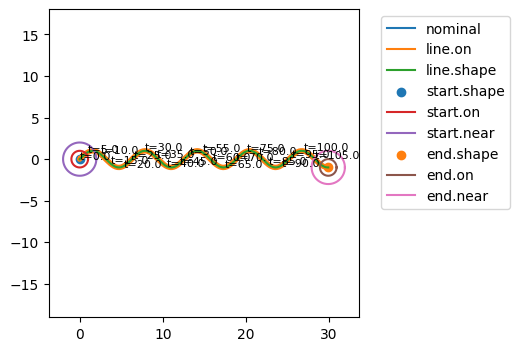

In [56]:
ec, hist = prop.nominal(mdl_hum)
plot_map(mdl_hum, hist)
ec

In [57]:
ec_comb, hist_comb = prop.parameter_sample(mdl_hum, ps_comb_mdl)

SCENARIOS COMPLETE:   0%|          | 0/60 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   2%|▏         | 1/60 [00:00<00:14,  4.19it/s]

SCENARIOS COMPLETE:   3%|▎         | 2/60 [00:00<00:14,  4.01it/s]

SCENARIOS COMPLETE:   5%|▌         | 3/60 [00:00<00:13,  4.16it/s]

SCENARIOS COMPLETE:   7%|▋         | 4/60 [00:00<00:13,  4.05it/s]

SCENARIOS COMPLETE:   8%|▊         | 5/60 [00:01<00:13,  4.06it/s]

SCENARIOS COMPLETE:  10%|█         | 6/60 [00:01<00:13,  4.09it/s]

SCENARIOS COMPLETE:  12%|█▏        | 7/60 [00:01<00:12,  4.12it/s]

SCENARIOS COMPLETE:  13%|█▎        | 8/60 [00:01<00:12,  4.06it/s]

SCENARIOS COMPLETE:  15%|█▌        | 9/60 [00:02<00:12,  4.13it/s]

SCENARIOS COMPLETE:  17%|█▋        | 10/60 [00:02<00:12,  4.07it/s]

SCENARIOS COMPLETE:  18%|█▊        | 11/60 [00:02<00:12,  4.06it/s]

SCENARIOS COMPLETE:  20%|██        | 12/60 [00:02<00:11,  4.10it/s]

SCENARIOS COMPLETE:  22%|██▏       | 13/60 [00:03<00:11,  4.08it/s]

SCENARIOS COMPLETE:  23%|██▎       | 14/60 [00:03<00:11,  4.03it/s]

SCENARIOS COMPLETE:  25%|██▌       | 15/60 [00:03<00:11,  4.03it/s]

SCENARIOS COMPLETE:  27%|██▋       | 16/60 [00:03<00:10,  4.04it/s]

SCENARIOS COMPLETE:  28%|██▊       | 17/60 [00:04<00:10,  4.08it/s]

SCENARIOS COMPLETE:  30%|███       | 18/60 [00:04<00:10,  4.07it/s]

SCENARIOS COMPLETE:  32%|███▏      | 19/60 [00:04<00:10,  4.08it/s]

SCENARIOS COMPLETE:  33%|███▎      | 20/60 [00:04<00:09,  4.09it/s]

SCENARIOS COMPLETE:  35%|███▌      | 21/60 [00:05<00:09,  4.07it/s]

SCENARIOS COMPLETE:  37%|███▋      | 22/60 [00:05<00:09,  4.09it/s]

SCENARIOS COMPLETE:  38%|███▊      | 23/60 [00:05<00:09,  4.10it/s]

SCENARIOS COMPLETE:  40%|████      | 24/60 [00:05<00:08,  4.11it/s]

SCENARIOS COMPLETE:  42%|████▏     | 25/60 [00:06<00:08,  4.09it/s]

SCENARIOS COMPLETE:  43%|████▎     | 26/60 [00:06<00:08,  4.08it/s]

SCENARIOS COMPLETE:  45%|████▌     | 27/60 [00:06<00:08,  4.09it/s]

SCENARIOS COMPLETE:  47%|████▋     | 28/60 [00:06<00:07,  4.03it/s]

SCENARIOS COMPLETE:  48%|████▊     | 29/60 [00:07<00:07,  4.01it/s]

SCENARIOS COMPLETE:  50%|█████     | 30/60 [00:07<00:07,  4.06it/s]

SCENARIOS COMPLETE:  52%|█████▏    | 31/60 [00:07<00:07,  4.03it/s]

SCENARIOS COMPLETE:  53%|█████▎    | 32/60 [00:07<00:06,  4.08it/s]

SCENARIOS COMPLETE:  55%|█████▌    | 33/60 [00:08<00:06,  4.07it/s]

SCENARIOS COMPLETE:  57%|█████▋    | 34/60 [00:08<00:06,  4.14it/s]

SCENARIOS COMPLETE:  58%|█████▊    | 35/60 [00:08<00:05,  4.19it/s]

SCENARIOS COMPLETE:  60%|██████    | 36/60 [00:08<00:05,  4.19it/s]

SCENARIOS COMPLETE:  62%|██████▏   | 37/60 [00:09<00:05,  4.14it/s]

SCENARIOS COMPLETE:  63%|██████▎   | 38/60 [00:09<00:05,  4.08it/s]

SCENARIOS COMPLETE:  65%|██████▌   | 39/60 [00:09<00:05,  4.06it/s]

SCENARIOS COMPLETE:  67%|██████▋   | 40/60 [00:09<00:04,  4.10it/s]

SCENARIOS COMPLETE:  68%|██████▊   | 41/60 [00:10<00:04,  4.08it/s]

SCENARIOS COMPLETE:  70%|███████   | 42/60 [00:10<00:04,  4.15it/s]

SCENARIOS COMPLETE:  72%|███████▏  | 43/60 [00:10<00:04,  4.11it/s]

SCENARIOS COMPLETE:  73%|███████▎  | 44/60 [00:10<00:03,  4.14it/s]

SCENARIOS COMPLETE:  75%|███████▌  | 45/60 [00:10<00:03,  4.15it/s]

SCENARIOS COMPLETE:  77%|███████▋  | 46/60 [00:11<00:03,  4.12it/s]

SCENARIOS COMPLETE:  78%|███████▊  | 47/60 [00:11<00:03,  4.13it/s]

SCENARIOS COMPLETE:  80%|████████  | 48/60 [00:11<00:02,  4.11it/s]

SCENARIOS COMPLETE:  82%|████████▏ | 49/60 [00:11<00:02,  4.09it/s]

SCENARIOS COMPLETE:  83%|████████▎ | 50/60 [00:12<00:02,  4.04it/s]

SCENARIOS COMPLETE:  85%|████████▌ | 51/60 [00:12<00:02,  4.04it/s]

SCENARIOS COMPLETE:  87%|████████▋ | 52/60 [00:12<00:01,  4.08it/s]

SCENARIOS COMPLETE:  88%|████████▊ | 53/60 [00:12<00:01,  3.95it/s]

SCENARIOS COMPLETE:  90%|█████████ | 54/60 [00:13<00:01,  3.85it/s]

SCENARIOS COMPLETE:  92%|█████████▏| 55/60 [00:13<00:01,  3.94it/s]

SCENARIOS COMPLETE:  93%|█████████▎| 56/60 [00:13<00:01,  3.97it/s]

SCENARIOS COMPLETE:  95%|█████████▌| 57/60 [00:13<00:00,  4.07it/s]

SCENARIOS COMPLETE:  97%|█████████▋| 58/60 [00:14<00:00,  3.99it/s]

SCENARIOS COMPLETE:  98%|█████████▊| 59/60 [00:14<00:00,  3.97it/s]

SCENARIOS COMPLETE: 100%|██████████| 60/60 [00:14<00:00,  4.03it/s]

SCENARIOS COMPLETE: 100%|██████████| 60/60 [00:14<00:00,  4.07it/s]

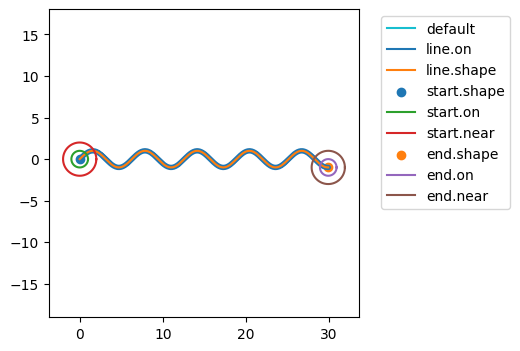

In [58]:
fig, ax = plot_map(mdl_hum, hist_comb)

(<Figure size 600x400 with 4 Axes>,
 array([<Axes: title={'center': 'flows.psfs.s.attention'}, xlabel=' '>,
        <Axes: title={'center': 'flows.motor_control.s.rpower'}, xlabel='time'>,
        <Axes: title={'center': 'flows.motor_control.s.lpower'}, xlabel='time'>,
        <Axes: >], dtype=object))

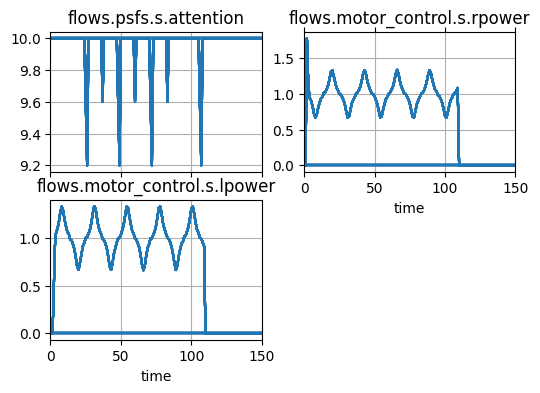

In [59]:
hist_comb.plot_line('flows.psfs.s.attention', 'flows.motor_control.s.rpower', 'flows.motor_control.s.lpower')

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='p.psfs.fatigue', ylabel='p.psfs.stress'>)

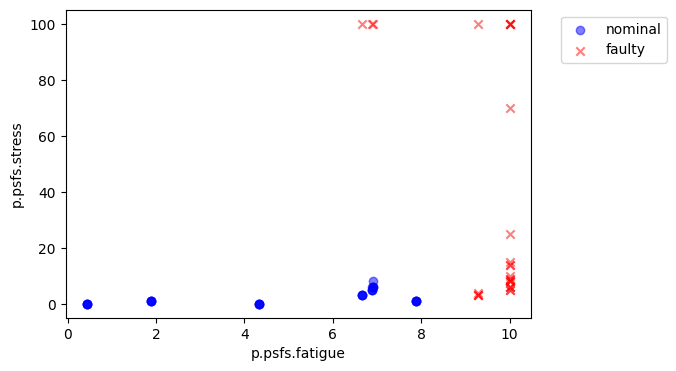

In [60]:
ne = NominalEnvelope(ps_comb_mdl, ec_comb, 'at_finish',
                     'p.psfs.fatigue', 'p.psfs.stress',
                     func=lambda x: x == True)
ne.plot_scatter()

(note, this is different in the turn case because of the long straightaway)

endclass: 
--rate:                              1.0
--cost:                                0
--prob:                              1.0
--expected_cost:                       0
--in_bound:                         True
--at_finish:                        True
--line_dist:                           1
--num_modes:                           0
--end_dist:                          0.0
--tot_deviation:    0.005246344989065292
--faults:                             {}
--classification:        nominal mission
--end_x:              29.813614084369863
--end_y:               17.26588133276667
--endpt:                        array(2)

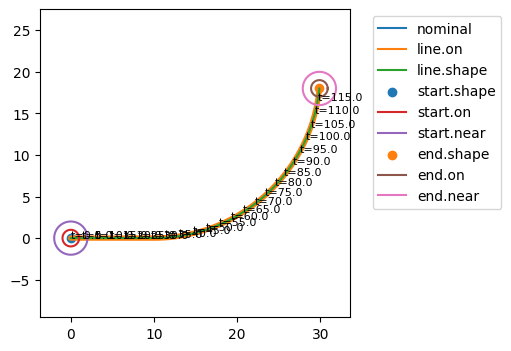

In [61]:
mdl_hum = RoverHuman(p={'ground': {'linetype': 'turn'}})
ec, hist = prop.nominal(mdl_hum)
plot_map(mdl_hum, hist)
ec

In [62]:
ec_comb, hist_comb = prop.parameter_sample(mdl_hum, ps_comb_mdl)

SCENARIOS COMPLETE:   0%|          | 0/60 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   2%|▏         | 1/60 [00:00<00:14,  4.01it/s]

SCENARIOS COMPLETE:   3%|▎         | 2/60 [00:00<00:14,  3.89it/s]

SCENARIOS COMPLETE:   5%|▌         | 3/60 [00:00<00:14,  4.03it/s]

SCENARIOS COMPLETE:   7%|▋         | 4/60 [00:00<00:13,  4.17it/s]

SCENARIOS COMPLETE:   8%|▊         | 5/60 [00:01<00:12,  4.28it/s]

SCENARIOS COMPLETE:  10%|█         | 6/60 [00:01<00:12,  4.18it/s]

SCENARIOS COMPLETE:  12%|█▏        | 7/60 [00:01<00:13,  3.89it/s]

SCENARIOS COMPLETE:  13%|█▎        | 8/60 [00:01<00:13,  3.90it/s]

SCENARIOS COMPLETE:  15%|█▌        | 9/60 [00:02<00:12,  4.01it/s]

SCENARIOS COMPLETE:  17%|█▋        | 10/60 [00:02<00:12,  4.09it/s]

SCENARIOS COMPLETE:  18%|█▊        | 11/60 [00:02<00:12,  3.99it/s]

SCENARIOS COMPLETE:  20%|██        | 12/60 [00:03<00:12,  3.76it/s]

SCENARIOS COMPLETE:  22%|██▏       | 13/60 [00:03<00:13,  3.50it/s]

SCENARIOS COMPLETE:  23%|██▎       | 14/60 [00:03<00:13,  3.53it/s]

SCENARIOS COMPLETE:  25%|██▌       | 15/60 [00:03<00:12,  3.68it/s]

SCENARIOS COMPLETE:  27%|██▋       | 16/60 [00:04<00:11,  3.87it/s]

SCENARIOS COMPLETE:  28%|██▊       | 17/60 [00:04<00:10,  4.00it/s]

SCENARIOS COMPLETE:  30%|███       | 18/60 [00:04<00:10,  4.05it/s]

SCENARIOS COMPLETE:  32%|███▏      | 19/60 [00:04<00:10,  3.79it/s]

SCENARIOS COMPLETE:  33%|███▎      | 20/60 [00:05<00:10,  3.76it/s]

SCENARIOS COMPLETE:  35%|███▌      | 21/60 [00:05<00:10,  3.79it/s]

SCENARIOS COMPLETE:  37%|███▋      | 22/60 [00:05<00:09,  3.84it/s]

SCENARIOS COMPLETE:  38%|███▊      | 23/60 [00:05<00:09,  3.79it/s]

SCENARIOS COMPLETE:  40%|████      | 24/60 [00:06<00:09,  3.86it/s]

SCENARIOS COMPLETE:  42%|████▏     | 25/60 [00:06<00:09,  3.85it/s]

SCENARIOS COMPLETE:  43%|████▎     | 26/60 [00:06<00:08,  3.88it/s]

SCENARIOS COMPLETE:  45%|████▌     | 27/60 [00:06<00:08,  3.93it/s]

SCENARIOS COMPLETE:  47%|████▋     | 28/60 [00:07<00:07,  4.09it/s]

SCENARIOS COMPLETE:  48%|████▊     | 29/60 [00:07<00:07,  4.15it/s]

SCENARIOS COMPLETE:  50%|█████     | 30/60 [00:07<00:07,  4.10it/s]

SCENARIOS COMPLETE:  52%|█████▏    | 31/60 [00:07<00:07,  4.05it/s]

SCENARIOS COMPLETE:  53%|█████▎    | 32/60 [00:08<00:06,  4.24it/s]

SCENARIOS COMPLETE:  55%|█████▌    | 33/60 [00:08<00:06,  4.16it/s]

SCENARIOS COMPLETE:  57%|█████▋    | 34/60 [00:08<00:06,  4.10it/s]

SCENARIOS COMPLETE:  58%|█████▊    | 35/60 [00:08<00:06,  4.11it/s]

SCENARIOS COMPLETE:  60%|██████    | 36/60 [00:09<00:05,  4.21it/s]

SCENARIOS COMPLETE:  62%|██████▏   | 37/60 [00:09<00:05,  3.92it/s]

SCENARIOS COMPLETE:  63%|██████▎   | 38/60 [00:09<00:05,  3.92it/s]

SCENARIOS COMPLETE:  65%|██████▌   | 39/60 [00:09<00:05,  3.90it/s]

SCENARIOS COMPLETE:  67%|██████▋   | 40/60 [00:10<00:05,  3.94it/s]

SCENARIOS COMPLETE:  68%|██████▊   | 41/60 [00:10<00:04,  3.95it/s]

SCENARIOS COMPLETE:  70%|███████   | 42/60 [00:10<00:04,  4.02it/s]

SCENARIOS COMPLETE:  72%|███████▏  | 43/60 [00:10<00:04,  4.01it/s]

SCENARIOS COMPLETE:  73%|███████▎  | 44/60 [00:11<00:03,  4.08it/s]

SCENARIOS COMPLETE:  75%|███████▌  | 45/60 [00:11<00:03,  4.08it/s]

SCENARIOS COMPLETE:  77%|███████▋  | 46/60 [00:11<00:03,  4.05it/s]

SCENARIOS COMPLETE:  78%|███████▊  | 47/60 [00:11<00:03,  4.06it/s]

SCENARIOS COMPLETE:  80%|████████  | 48/60 [00:12<00:02,  4.10it/s]

SCENARIOS COMPLETE:  82%|████████▏ | 49/60 [00:12<00:02,  4.07it/s]

SCENARIOS COMPLETE:  83%|████████▎ | 50/60 [00:12<00:02,  4.14it/s]

SCENARIOS COMPLETE:  85%|████████▌ | 51/60 [00:12<00:02,  4.18it/s]

SCENARIOS COMPLETE:  87%|████████▋ | 52/60 [00:13<00:01,  4.23it/s]

SCENARIOS COMPLETE:  88%|████████▊ | 53/60 [00:13<00:01,  4.26it/s]

SCENARIOS COMPLETE:  90%|█████████ | 54/60 [00:13<00:01,  4.25it/s]

SCENARIOS COMPLETE:  92%|█████████▏| 55/60 [00:13<00:01,  4.21it/s]

SCENARIOS COMPLETE:  93%|█████████▎| 56/60 [00:13<00:00,  4.25it/s]

SCENARIOS COMPLETE:  95%|█████████▌| 57/60 [00:14<00:00,  4.17it/s]

SCENARIOS COMPLETE:  97%|█████████▋| 58/60 [00:14<00:00,  4.19it/s]

SCENARIOS COMPLETE:  98%|█████████▊| 59/60 [00:14<00:00,  4.27it/s]

SCENARIOS COMPLETE: 100%|██████████| 60/60 [00:14<00:00,  4.24it/s]

SCENARIOS COMPLETE: 100%|██████████| 60/60 [00:14<00:00,  4.02it/s]

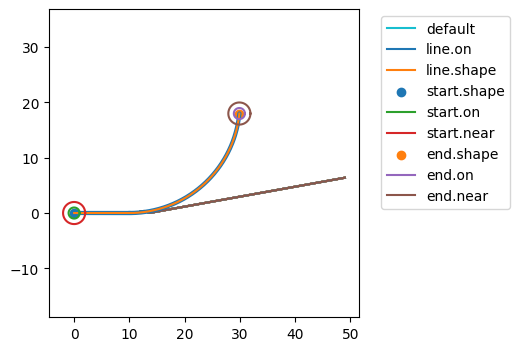

In [63]:
fig, ax = plot_map(mdl_hum, hist_comb)

(<Figure size 600x400 with 4 Axes>,
 array([<Axes: title={'center': 'flows.psfs.s.attention'}, xlabel=' '>,
        <Axes: title={'center': 'flows.motor_control.s.rpower'}, xlabel='time'>,
        <Axes: title={'center': 'flows.motor_control.s.lpower'}, xlabel='time'>,
        <Axes: >], dtype=object))

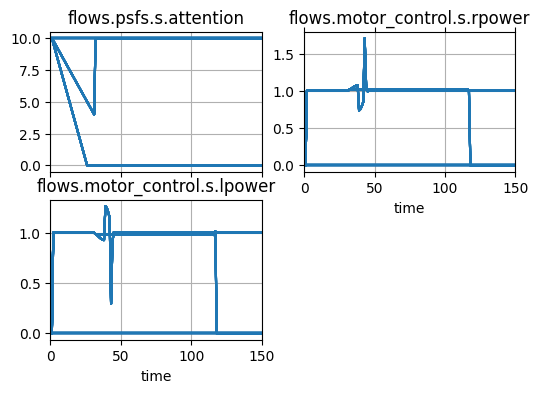

In [64]:
hist_comb.plot_line('flows.psfs.s.attention', 'flows.motor_control.s.rpower', 'flows.motor_control.s.lpower')

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='p.psfs.fatigue', ylabel='p.psfs.stress'>)

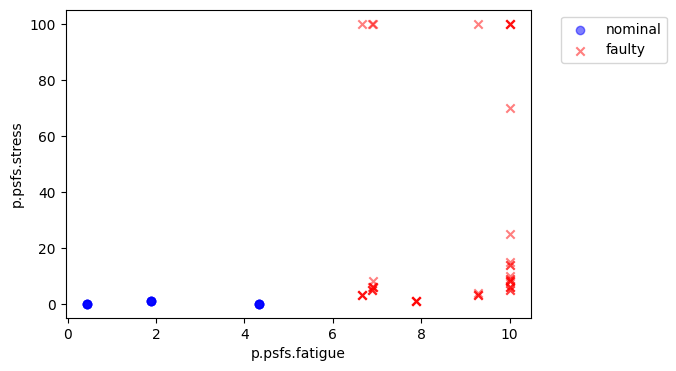

In [65]:
ne = NominalEnvelope(ps_comb_mdl, ec_comb, 'at_finish',
                     'p.psfs.fatigue', 'p.psfs.stress',
                     func=lambda x: x == True)
ne.plot_scatter()

We can thus see how degradation time effects this:

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='inputparams.t', ylabel='inputparams.rep'>)

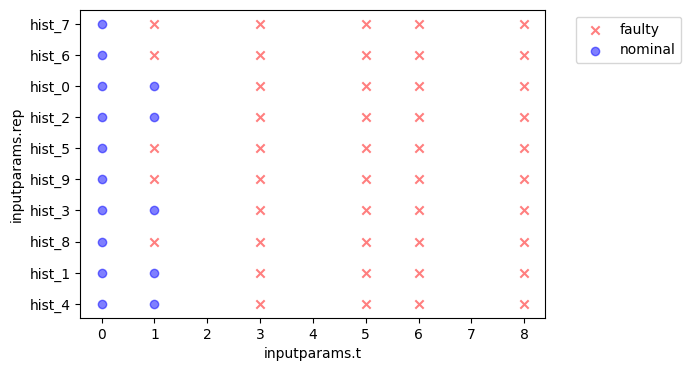

In [66]:
ne = NominalEnvelope(ps_comb_mdl, ec_comb, 'at_finish',
                     'inputparams.t', 'inputparams.rep',
                     func=lambda x: x == True)
ne.plot_scatter()

To re-implement:
- Need to be able to jointly plot/tabulate by single-day time + multi-day time
- Combining approaches?

As for the human resilience:

In [67]:
ec_nest, hist_nest, app_nest = prop.nested_sample(mdl, phs, faultdomains={'drive_faults':  (('all_fxnclass_modes', 'Drive'), {})},
                                                  faultsamples={'drive_faults': (('fault_phases', 'drive_faults', "start"), {})},
                                                  pool=mp.Pool(5))

NESTED SCENARIOS COMPLETE:   0%|          | 0/40 [00:00<?, ?it/s]

NESTED SCENARIOS COMPLETE:   2%|▎         | 1/40 [00:00<00:24,  1.56it/s]

NESTED SCENARIOS COMPLETE:   5%|▌         | 2/40 [00:00<00:15,  2.45it/s]

NESTED SCENARIOS COMPLETE:   8%|▊         | 3/40 [00:01<00:12,  3.00it/s]

NESTED SCENARIOS COMPLETE:  10%|█         | 4/40 [00:01<00:10,  3.37it/s]

NESTED SCENARIOS COMPLETE:  12%|█▎        | 5/40 [00:01<00:09,  3.58it/s]

NESTED SCENARIOS COMPLETE:  15%|█▌        | 6/40 [00:01<00:09,  3.65it/s]

NESTED SCENARIOS COMPLETE:  18%|█▊        | 7/40 [00:02<00:11,  2.88it/s]

NESTED SCENARIOS COMPLETE:  20%|██        | 8/40 [00:02<00:10,  3.11it/s]

NESTED SCENARIOS COMPLETE:  22%|██▎       | 9/40 [00:03<00:12,  2.47it/s]

NESTED SCENARIOS COMPLETE:  25%|██▌       | 10/40 [00:03<00:13,  2.18it/s]

NESTED SCENARIOS COMPLETE:  28%|██▊       | 11/40 [00:04<00:11,  2.51it/s]

NESTED SCENARIOS COMPLETE:  30%|███       | 12/40 [00:04<00:09,  2.90it/s]

NESTED SCENARIOS COMPLETE:  32%|███▎      | 13/40 [00:04<00:08,  3.19it/s]

NESTED SCENARIOS COMPLETE:  35%|███▌      | 14/40 [00:04<00:07,  3.47it/s]

NESTED SCENARIOS COMPLETE:  38%|███▊      | 15/40 [00:05<00:06,  3.63it/s]

NESTED SCENARIOS COMPLETE:  40%|████      | 16/40 [00:05<00:06,  3.82it/s]

NESTED SCENARIOS COMPLETE:  42%|████▎     | 17/40 [00:05<00:08,  2.81it/s]

NESTED SCENARIOS COMPLETE:  45%|████▌     | 18/40 [00:06<00:07,  3.00it/s]

NESTED SCENARIOS COMPLETE:  48%|████▊     | 19/40 [00:06<00:06,  3.25it/s]

NESTED SCENARIOS COMPLETE:  50%|█████     | 20/40 [00:06<00:05,  3.44it/s]

NESTED SCENARIOS COMPLETE:  52%|█████▎    | 21/40 [00:07<00:07,  2.65it/s]

NESTED SCENARIOS COMPLETE:  55%|█████▌    | 22/40 [00:07<00:06,  2.99it/s]

NESTED SCENARIOS COMPLETE:  57%|█████▊    | 23/40 [00:07<00:05,  3.26it/s]

NESTED SCENARIOS COMPLETE:  60%|██████    | 24/40 [00:07<00:04,  3.49it/s]

NESTED SCENARIOS COMPLETE:  62%|██████▎   | 25/40 [00:08<00:05,  2.64it/s]

NESTED SCENARIOS COMPLETE:  65%|██████▌   | 26/40 [00:09<00:06,  2.23it/s]

NESTED SCENARIOS COMPLETE:  68%|██████▊   | 27/40 [00:09<00:06,  2.01it/s]

NESTED SCENARIOS COMPLETE:  70%|███████   | 28/40 [00:10<00:06,  1.91it/s]

NESTED SCENARIOS COMPLETE:  72%|███████▎  | 29/40 [00:10<00:05,  1.85it/s]

NESTED SCENARIOS COMPLETE:  75%|███████▌  | 30/40 [00:11<00:04,  2.22it/s]

NESTED SCENARIOS COMPLETE:  78%|███████▊  | 31/40 [00:11<00:03,  2.57it/s]

NESTED SCENARIOS COMPLETE:  80%|████████  | 32/40 [00:11<00:02,  2.89it/s]

NESTED SCENARIOS COMPLETE:  82%|████████▎ | 33/40 [00:11<00:02,  3.06it/s]

NESTED SCENARIOS COMPLETE:  85%|████████▌ | 34/40 [00:12<00:01,  3.23it/s]

NESTED SCENARIOS COMPLETE:  88%|████████▊ | 35/40 [00:12<00:01,  3.39it/s]

NESTED SCENARIOS COMPLETE:  90%|█████████ | 36/40 [00:12<00:01,  3.54it/s]

NESTED SCENARIOS COMPLETE:  92%|█████████▎| 37/40 [00:13<00:01,  2.70it/s]

NESTED SCENARIOS COMPLETE:  95%|█████████▌| 38/40 [00:13<00:00,  3.03it/s]

NESTED SCENARIOS COMPLETE:  98%|█████████▊| 39/40 [00:13<00:00,  3.30it/s]

NESTED SCENARIOS COMPLETE: 100%|██████████| 40/40 [00:13<00:00,  3.52it/s]

NESTED SCENARIOS COMPLETE: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]

In [68]:
nc = NestedComparison(ec_nest, phs, ['inputparams.t'], app_nest, ['fault'], metrics=['tot_deviation', 'end_dist'], default_stat=np.mean, ci_metrics=['end_dist', 'tot_deviation'])

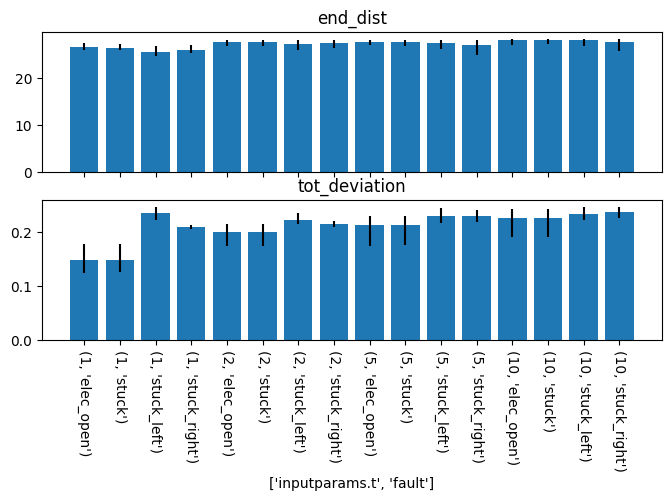

In [69]:
nc.sort_by_factor("fault")
nc.sort_by_factor("inputparams.t")
fig, ax = nc.as_plots('end_dist', 'tot_deviation', figsize=(8,4))

In [70]:
# fig.savefig("human_resilience_degradation.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

## Combined Degradation

Idea: make same resilience plots as before but with degradation of resilience to drive faults at 0, 4, and 8 hours of fatigue.

Need method of doing this:
- take params for one and replace with the other (kind of hacky and requires independence)
- create composite of both? (how do you determine the merge between output params?)
- use a combined method with both histories as input and sample over t_life and t_day (use this one)

Resilience assessment